In [1]:
import numpy as np
import qutip as qt
from scipy.integrate import quad
from scipy.linalg import det
from scipy.optimize import basinhopping

# plotting setup
import matplotlib.pyplot as plt
plt.style.use('SciencePlots-APS.mplstyle')

In [2]:
#======================#
# PROGRAM MODULES
#======================#

#######################
# Reduce density matrix
#######################
def omega_phi(lam, phi):
    """
    Energy spectrum of the transverse Ising chain.
    """
    omega_val = np.sqrt((lam * np.sin(phi))**2 + (1. + lam*np.cos(phi))**2 )
    return omega_val

def G_k(lam, k):
    """Fourier transform of the spin-spin correlation function."""
    integrand_1 = lambda phi: np.cos(phi * k) * (1. + lam * np.cos(phi)) / omega_phi(lam, phi)
    integrand_2 = lambda phi: np.sin(phi * k) * np.sin(phi) * lam / omega_phi(lam, phi)
    integral_1, _ = quad(integrand_1, 0., np.pi)
    integral_2, _ = quad(integrand_2, 0., np.pi)
    return (integral_1 - integral_2) / np.pi

def magnetization(lam):
    """Compute the magnetization of the spin-1/2 Ising chain."""
    integrand = lambda phi: (1. + lam * np.cos(phi)) / omega_phi(lam, phi)
    integral, _ = quad(integrand, 0., np.pi)
    return -integral / np.pi

def correlation_xx(lam, nn=False):
    """Nearest or next-nearest neighbor correlation <σx_i σx_i+n>."""
    if nn:
        return det(np.array([[G_k(lam, -1), G_k(lam, -2)], [G_k(lam, 0), G_k(lam, -1)]]))
    return G_k(lam, -1)

def correlation_yy(lam, nn=False):
    """Nearest or next-nearest neighbor correlation <σy_i σy_i+n>."""
    if nn:
        return det(np.array([[G_k(lam, 1), G_k(lam, 0)], [G_k(lam, 2), G_k(lam, 1)]]))
    return G_k(lam, 1)

def correlation_zz(lam, magnetization_val, nn=False):
    """Nearest or next-nearest neighbor correlation <σz_i σz_i+n>."""
    k = 2 if nn else 1
    return magnetization_val**2 - G_k(lam, k) * G_k(lam, -k)

def rho_ij(lam, nn=False):
    """Reduced density matrix of the Ising chain."""
    magnetization_val = magnetization(lam)
    corr_xx = correlation_xx(lam, nn)
    corr_yy = correlation_yy(lam, nn)
    corr_zz = correlation_zz(lam, magnetization_val, nn)
    
    u_plus = 0.25 + magnetization_val/2 + corr_zz/4
    u_minus = 0.25 - magnetization_val/2 + corr_zz/4
    w = (1.-corr_zz)/4
    x = (corr_xx + corr_yy)/4
    y = (corr_xx - corr_yy)/4

    return np.array([
        [u_plus, 0, 0, y],
        [0, w, x, 0],
        [0, x, w, 0],
        [y, 0, 0, u_minus]
    ])

#######################
# Concurrence
#######################
def concurrence(rho):
    # Find the number of sites in the system
    N = int(np.log2(rho.shape[0]))
    # Convert numpy.ndarray to qutip.Qobj if necessary
    if isinstance(rho, np.ndarray):
        rho = qt.Qobj(rho, dims=[[2]*N]*2)
    # Compute the spin-flipped state
    rho_tilde = qt.tensor(qt.sigmay(), qt.sigmay()) * rho.conj() * qt.tensor(qt.sigmay(), qt.sigmay())
    # Compute the square root of the matrix
    R = (rho * rho_tilde).sqrtm()
    # Compute the eigenvalues of the matrix R (sorted in descending order)
    eigvals = np.sort(R.eigenenergies())[::-1].real
    # Compute the concurrence
    concurrence = max(0., eigvals[0] - eigvals[1] - eigvals[2] - eigvals[3])
    return concurrence

#######################
# Quantum Discord
#######################
def basis_qd(theta, phi):
    """
    Basis for the quantum discord.
    """
    # Define the basis states
    base_1 = np.cos(theta)*qt.basis(2, 0) + np.exp(1j*phi)*np.sin(theta)*qt.basis(2, 1)
    base_2 = np.exp(-1j*phi)*np.sin(theta)*qt.basis(2, 0) - np.cos(theta)*qt.basis(2, 1)
    return [base_1, base_2]

def entropy_vn(rho):
    """
    Von Neumann entropy of a density matrix.
    """
    
    # Find the number of sites in the system
    N = int(np.log2(rho.shape[0]))
    # Convert numpy.ndarray to qutip.Qobj if necessary
    if isinstance(rho, np.ndarray):
        rho = qt.Qobj(rho, dims=[[2]*N]*2)
    # Compute the Von Neumann entropy
    entropy = qt.entropy_vn(rho)
    return entropy

def entropy_conditional(rho_AB, base_b):
    # Find the number of sites in the system
    N = int(np.log2(rho_AB.shape[0]))
    # Convert numpy.ndarray to qutip.Qobj if necessary
    if isinstance(rho_AB, np.ndarray):
        rho_AB = qt.Qobj(rho_AB, dims=[[2]*N]*2)
    # Compute the conditional entropy
    entropy = 0.0
    for i in range(len(base_b)):
        # Projector onto the basis state base_b[i]
        proj_b = base_b[i] * base_b[i].dag()
        # Tensor product with identity to form the measurement operator
        Pi = qt.tensor(qt.qeye(2), proj_b)
        # Probability of measurement outcome
        pj = np.real((qt.tensor(qt.qeye(2), proj_b) * rho_AB).tr() )
        if pj < 1e-12:
            pj = 1e-12
        # Conditional entropy
        rho_A_phi = (Pi * rho_AB * Pi)/ pj
        entropy += pj * qt.entropy_vn(rho_A_phi)
    return entropy

def quantum_discord(rho_AB):
    # Find the number of sites in the system
    N = int(np.log2(rho_AB.shape[0]))
    # Convert numpy.ndarray to qutip.Qobj if necessary
    if isinstance(rho_AB, np.ndarray):
        rho_AB = qt.Qobj(rho_AB, dims=[[2]*N]*2)
    
    def obj_func(params):
        theta, phi = params
        base_b = basis_qd(theta, phi)
        # von Neumann entropy of the rho_AB
        H_AB = entropy_vn(rho_AB)
        # von Neumann entropy of the reduced rho_A
        H_A = entropy_vn(partial_trace(rho_AB, 1))
        # Conditional entropy
        H_A_B = entropy_conditional(rho_AB, base_b)
        # Quantum discord
        discord = H_A - H_AB + H_A_B
        return float(discord)  # Ensure the return value is a scalar
    
    # Bounds for the optimization
    bounds = [(0, np.pi), (0, 2*np.pi)]
    # Initial guess
    init_guess = np.array([np.pi/2, 0])
    
    # Perform the optimization to find the minimum of the objective function (quantum discord)
    minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds}
    res = basinhopping(obj_func, init_guess, minimizer_kwargs=minimizer_kwargs, niter=100)
    return res.fun    

#################################
# General mathematical functions
#################################
def partial_trace(rho, idx):
    # Find the number of sites in the system
    N = int(np.log2(rho.shape[0]))
    # Convert numpy.ndarray to qutip.Qobj if necessary
    if isinstance(rho, np.ndarray):
        rho = qt.Qobj(rho, dims=[[2]*N]*2)
    # Compute the partial trace
    rho_ptrace = rho.ptrace(idx)
    return rho_ptrace.full()

## Concurrence

In [3]:
lambdas = np.linspace(0.5, 1.5, 201)

# Compute concurrence for nearest-neighbor
concurrence_nn = np.zeros_like(lambdas)
for i in range(len(lambdas)):
    rho = rho_ij(lambdas[i], nn=False)
    concurrence_nn[i] = concurrence(rho)

# Compute concurrence for next-nearest-neighbor
concurrence_nnn = np.zeros_like(lambdas)
for i in range(len(lambdas)):
    rho = rho_ij(lambdas[i], nn=True)
    concurrence_nnn[i] = concurrence(rho) 

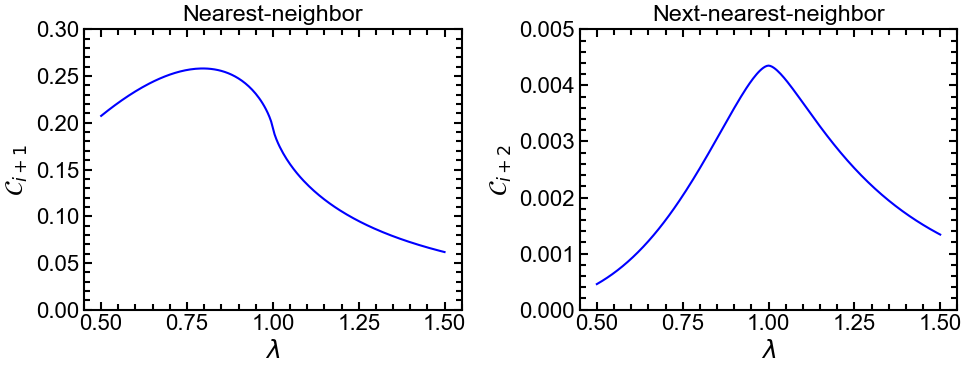

In [4]:
# Plot the result into 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the concurrence for nearest-neighbor
ax[0].plot(lambdas, concurrence_nn, 'b-')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\mathcal{C}_{i+1}$')
ax[0].set_ylim(0, 0.3)
ax[0].set_title('Nearest-neighbor')

# Plot the concurrence for next-nearest-neighbor
ax[1].plot(lambdas, concurrence_nnn, 'b-')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel(r'$\mathcal{C}_{i+2}$')
ax[1].set_ylim(0, 0.005)
ax[1].set_title('Next-nearest-neighbor')

plt.tight_layout()
plt.show()

## Quantum Discord

In [5]:
# Compute quantum discord for nearest-neighbor
discord_nn = np.zeros_like(lambdas)
for i in range(len(lambdas)):
    rho = rho_ij(lambdas[i], nn=False)
    discord_nn[i] = quantum_discord(rho)

# Compute quantum discord for next-nearest-neighbor
discord_nnn = np.zeros_like(lambdas)
for i in range(len(lambdas)):
    rho = rho_ij(lambdas[i], nn=True)
    discord_nnn[i] = quantum_discord(rho)

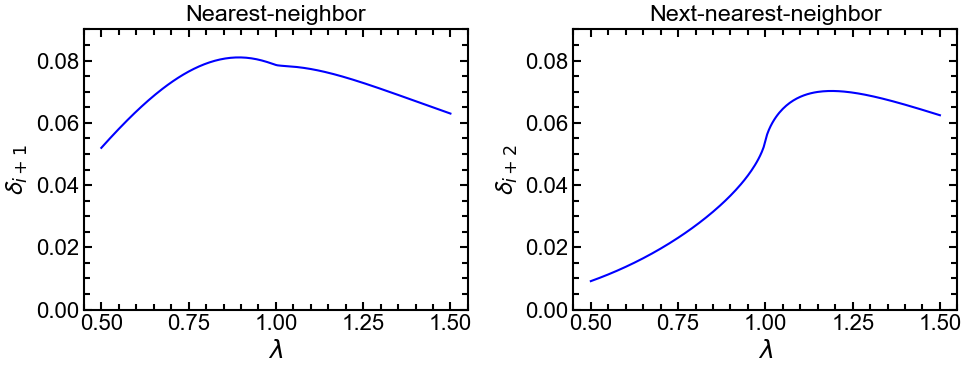

In [8]:
# Plot the result into 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the quantum discord for nearest-neighbor
ax[0].plot(lambdas, discord_nn, 'b-')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\mathcal{\delta}_{i+1}$')
ax[0].set_ylim(0, 0.09)
ax[0].set_title('Nearest-neighbor')

# Plot the quantum discord for next-nearest-neighbor
ax[1].plot(lambdas, discord_nnn, 'b-')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel(r'$\mathcal{\delta}_{i+2}$')
ax[1].set_ylim(0, 0.09)
ax[1].set_title('Next-nearest-neighbor')

plt.tight_layout()
plt.show()